# Setup

In [2]:
# Auto reload settings
#%%

%load_ext autoreload
%autoreload 2
!jupyter nbextension enable --py widgetsnbextension


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [1]:
# Imports

%load_ext autoreload
import sys

from entropy_aware_search.hf_utils import DataArguments, ModelArguments, get_tokenizer, get_model
from entropy_aware_search.utils import compute_average_across_sequences, process_datapoint
from fine_tune_writing_prompts import get_writing_prompt_dataset, get_tokenized_prompt_dataset
from utils import get_compute_metrics_func
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling
from parlai.utils.strings import colorize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import copy
pd.options.plotting.backend = "matplotlib"



In [3]:
# Load GPT2 model fine-tuned on writing prompts

# gpt2_writing_prompt_modelfile = "/home/mila/a/arorakus/scratch/ews/finetuned_writing_prompts/08-14-2022-11-03/checkpoint-71000/"
gpt2_writing_prompt_modelfile = "/home/mila/a/arorakus/scratch/ews/finetuned_writing_prompts/08-18-2022-05-33-01/checkpoint-21000/"
# gpt2_writing_prompt_modelfile = 'gpt2-large'
model_args = ModelArguments(
    model_name_or_path=gpt2_writing_prompt_modelfile,   
)
gpt2_model = get_model(model_args)
gpt2_model.to('cuda')
tokenizer = get_tokenizer(model_args)
tokenizer.pad_token = tokenizer.eos_token
gpt2_model = gpt2_model.to('cuda')

compute_metrics = get_compute_metrics_func(experiment_id="jupyter_ipynb", metric_names=['accuracy', 'mauve'])

In [22]:
from typing import List, Union
from parlai.utils.strings import colorize
import copy
def compute_ngram_repeats(context: Union[str, List], model_text: Union[str, List], n=3, splitted=False):
    cgrams = {}
    # compute N grams of the context
    
    if not splitted:
        context = context.split(' ')
        model_text = model_text.split(' ')

    for i in range(n, len(context) + 1):
        ngram = ' '.join(context[i - n : i])
        cgrams[ngram] = True
    # compute N grams of the model response
    creps = 0
    lreps = 0
    repetition_idxs = [0] * len(model_text)
    lreps_idxs = [0] * len(model_text)
    creps_idxs = [0] * len(model_text)
    
    lgrams = {}

    for i in range(n, len(model_text) + 1):
        ngram = ' '.join(model_text[i - n : i])
        
        if ngram in cgrams:
            creps = creps + 1
            repetition_idxs[i-1] = 1
            creps_idxs[i-1] = 1
        
        if ngram in lgrams:
            lreps = lreps + 1
            repetition_idxs[i-1] = 1
            lreps_idxs[i-1] = 1
           
        lgrams[ngram] = True
    
    for i in range(n-1, len(model_text)):
        if repetition_idxs[i] == 1:
            for j in range(1, n):
                repetition_idxs[i-j] = 1

        if creps_idxs[i] == 1:
            for j in range(1, n):
                creps_idxs[i-j] = 1

        if lreps_idxs[i] == 1:
            for j in range(1, n):
                lreps_idxs[i-j] = 1

    return creps + lreps, creps, lreps, repetition_idxs, creps_idxs, lreps_idxs


def print_with_colors(text, repeat_indices):
    colorized_tokens = []
    tokenized_text = text.split(" ")
    
    is_repeat_indices = copy.copy(repeat_indices)
    for (token, is_repeat) in zip(tokenized_text, is_repeat_indices):
       
        if is_repeat:
            colorized_token = colorize(token, "red")
        else:
            colorized_token = token

        colorized_tokens.append(colorized_token)

    return " ".join(colorized_tokens)

def print_sample(context, model_text, repeat_type='all'):
    _, _, _, arep_idxs, crep_idxs, lrep_idxs = compute_ngram_repeats(context, model_text)
    # print(context)

    rep_idxs = None
    if repeat_type == 'all':
        rep_idxs = arep_idxs
    elif repeat_type == 'context':
        rep_idxs = crep_idxs
    elif repeat_type == 'labels':
        rep_idxs = lrep_idxs

    print(print_with_colors(model_text, rep_idxs))

In [23]:
# Plot mean and std average entropy

def plot_avg_entropies_mean_std(entropies, ax, label, color='red', linewidth=1, std_dev=1):
    entropy_mean = np.ma.mean(entropies, axis=0)
    entropy_std = np.ma.std(entropies, axis=0)
    sns.lineplot(y=entropy_mean, x=np.arange(len(entropy_mean)), 
                    ax=ax, label=label, color=color, linewidth=linewidth)
    # sns.lineplot(entropy_mean, ax=ax, label=label)

    ax.set_ylim(0,6)
    ax.fill_between(range(len(entropy_mean)), entropy_mean -  std_dev * entropy_std, 
                                                entropy_mean +  std_dev * entropy_std, alpha=0.1, color=color)
    # ax=ax.set_xticks(np.arange(len(entropy_mean)), step=100)


# Constants

In [24]:
# Data
orig_wp = '/home/mila/a/arorakus/wdir/entropy_aware_search/data/writingPrompts/generated/orig.txt'
gpt2_greedy_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/writingPrompts/generated/finetuned/greedy.csv"
gpt2_nucleus_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/writingPrompts/generated/finetuned/top_p_0.9.csv"
gpt2_topk_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/writingPrompts/generated/finetuned/top_k_30.csv"
gpt2_typical_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/writingPrompts/generated/finetuned/typical_p_0.95.csv"

In [25]:
NUM_SEQ=1000
MAX_LEN = 1000

# Entropy of Human Data

In [26]:
human_dataframe = pd.read_csv(orig_wp, sep='\t', names=['context', 'model_text'])
human_dataframe['model_text'] = human_dataframe['model_text'].apply(lambda txt: txt.replace("<newline>", "\n"))

In [27]:
human_datapoint = human_dataframe.sample(1).iloc[0]
print(human_datapoint.context)
print()
print(print_sample(human_datapoint.context, human_datapoint.model_text))

[ WP ] You were the first person to successfully cheat death by transferring your mind to a computer before dying . It 's been 10 years , and you 've learned you will pay for cheating death , with a death far worse than ... [ end of transmission ]

Nobody took me seriously . Back in the teens , I had no friends and no deep intellectual connections with anyone . I had spent two decades high and drunk off my ass , and I had the wild ideas scrawled in over a thousand notebook pages to prove it . Mired in misery , trawling through another lightless tunnel , one day the answer hit me like a slab of meat hits a meat packer who dares to daydream . The idea was so simple , too simple . I tested it with the materials anyone could find just lying around as trash . It worked ! Persistence of memory had the curious side effect of blacking out my living memory during the same time . Within weeks , I was fully electronic . I became robustly computational . Before I knew what became of me , I had los

## Compute Average entropy across sequences.

In [29]:
human_avg_entropy_pd, human_entropies = compute_average_across_sequences(human_dataframe, gpt2_model, tokenizer, column_prefix='human_generated',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)
human_avg_ma_entropy_pd, human_ma_entropies = compute_average_across_sequences(human_dataframe, gpt2_model, tokenizer, column_prefix='human_generated', width=5,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

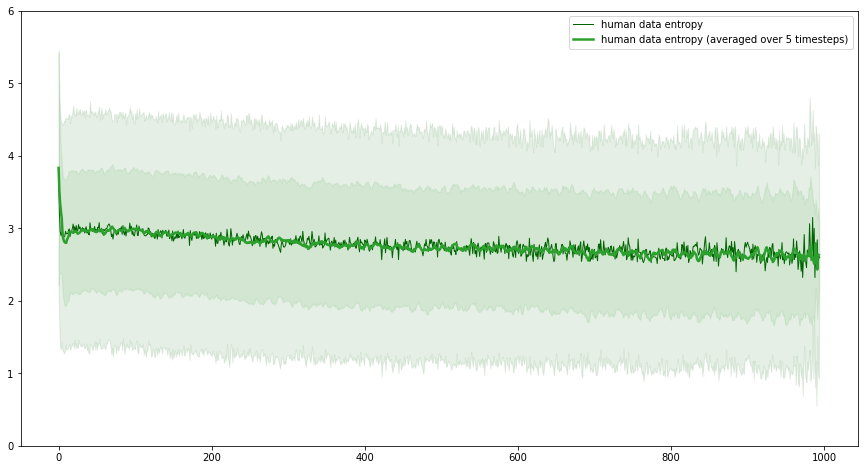

In [30]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_avg_entropies_mean_std(human_entropies, ax, 'human data entropy', color='darkgreen')
plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', linewidth=2.5)

## Examples of generation

In [31]:

lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=5, max_len=MAX_LEN,
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


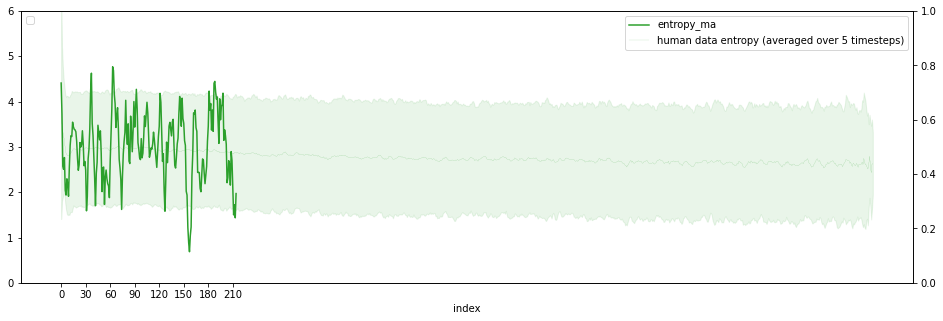

In [32]:
fig, ax = plt.subplots(figsize=(16, 5))
ax2 = ax.twinx()
# lpdh.plot.bar(x='index', y='is_lrep', ax=ax2, fill=True, rot='60')
ax2.legend(loc=2)

# lpdh.plot(x="index", y='entropy', ylim=(0,8), ax=ax, color='darkgreen')
lpdh.plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, color='tab:green')
ax.set_xticks(np.arange(len(lpdh['index']), step=30))

plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

# Entropy of Model Data

In [33]:
model_greedy_dataframe = pd.read_csv(gpt2_greedy_generation, sep='\t', names=['context', 'model_text'])
model_greedy_dataframe['model_text'] = model_greedy_dataframe['model_text'].apply(lambda txt: txt.replace("<newline>", "\n"))

model_nucleus_dataframe = pd.read_csv(gpt2_nucleus_generation, sep='\t', names=['context', 'model_text'])
model_nucleus_dataframe['model_text'] = model_nucleus_dataframe['model_text'].apply(lambda txt: txt.replace("<newline>", "\n"))

model_topk_dataframe = pd.read_csv(gpt2_topk_generation, sep='\t', names=['context', 'model_text'])
model_topk_dataframe['model_text'] = model_topk_dataframe['model_text'].apply(lambda txt: txt.replace("<newline>", "\n"))

model_typical_dataframe = pd.read_csv(gpt2_typical_generation, sep='\t', names=['context', 'model_text'])
model_typical_dataframe['model_text'] = model_typical_dataframe['model_text'].apply(lambda txt: txt.replace("<newline>", "\n"))


## Examples of various amounts of 3-gram repetition.

In [34]:
human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()

In [35]:

greedy_sample = model_greedy_dataframe.iloc[human_datapoint_idx]
nucleus_sample = model_nucleus_dataframe.iloc[human_datapoint_idx]
topk_sample = model_topk_dataframe.iloc[human_datapoint_idx]
typical_sample = model_typical_dataframe.iloc[human_datapoint_idx]

print("Context:")
print(human_datapoint.context)
print()
print("Greedy Model Text: ")
print_sample(human_datapoint.context, greedy_sample.model_text.replace("\n", "\\n"))
print()
print("Nucleus sampled Model Text:")
print_sample(human_datapoint.context, nucleus_sample.model_text.replace("\n", "\\n"))
print()
print("Top-K sampled Model Text:")
print_sample(human_datapoint.context, topk_sample.model_text.replace("\n", "\\n"))
print()

print("Typical Model Text: ")
print_sample(human_datapoint.context, typical_sample.model_text.replace("\n", "\\n"))


Context:
[ WP ] You were the first person to successfully cheat death by transferring your mind to a computer before dying . It 's been 10 years , and you 've learned you will pay for cheating death , with a death far worse than ... [ end of transmission ]

Greedy Model Text: 
The first time I died, I was a little bit surprised. I wasn't expecting to die, but I wasn't expecting to die in a way that wasn't my fault. I wasn't expecting to die in a way that wasn't my fault. \n \n I wasn't expecting to die in a way that wasn't my fault. \n \n I wasn't expecting to die in a way that wasn't my fault. \n \n I wasn't expecting to die in a way that wasn't my fault. \n \n I wasn't expecting to die in a way that wasn't my fault. \n \n I wasn't expecting to die in a way that wasn't my fault. \n \n I wasn't expecting to die in a way that wasn't my fault. \n \n I wasn't expecting to die in a way that wasn't my fault. \n \n I wasn't expecting to die in a way that wasn't my fault. \n \n I wasn't expec

<AxesSubplot:xlabel='index'>

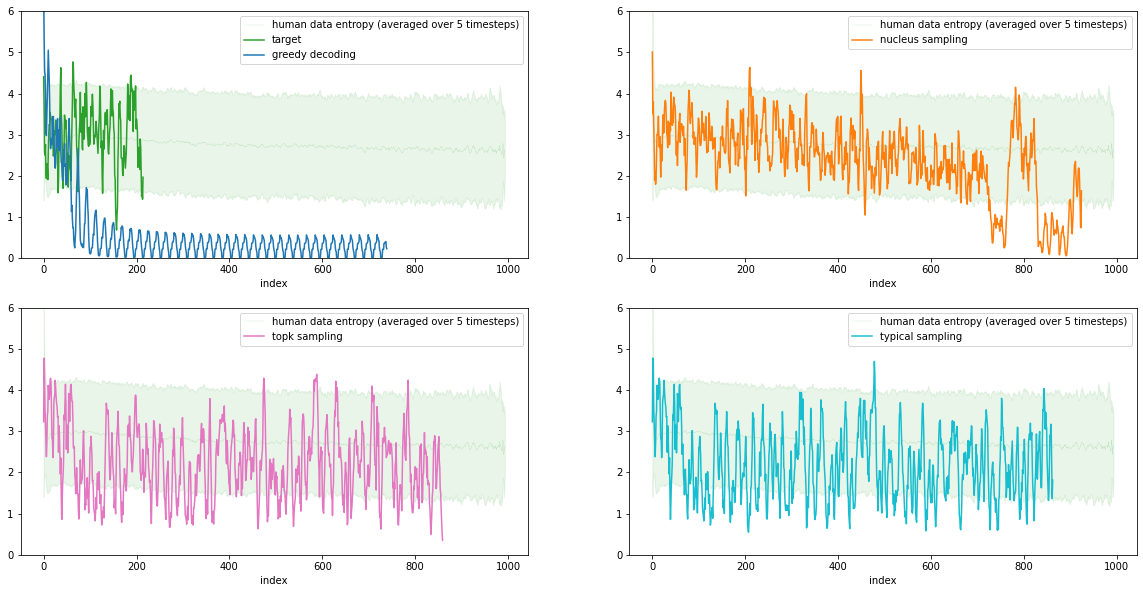

In [36]:
greedy_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=greedy_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

nucleus_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=nucleus_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

topk_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=topk_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

typical_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=typical_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

fig, axs = plt.subplots(2,2, figsize=(20, 10))
plot_avg_entropies_mean_std(human_ma_entropies, axs[0, 0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
lpdh.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0,0], label='target', color='tab:green')
greedy_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0, 0], label='greedy decoding', color='tab:blue')
# lpdm.plot(x="index", y='dent', ylim=(-4,6), ax=ax)

plot_avg_entropies_mean_std(human_ma_entropies, axs[0, 1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
nucleus_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0, 1], label='nucleus sampling', color='tab:orange')

plot_avg_entropies_mean_std(human_ma_entropies, axs[1,0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
topk_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1,0], label='topk sampling', color='tab:pink')

plot_avg_entropies_mean_std(human_ma_entropies, axs[1,1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
typical_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1,1], label='typical sampling', color='tab:cyan')

# # ax.set_xticklabels(lpdm['token'])
# ax.set_xlabel("Timestep")
# ax.set_ylabel("Entropy (Averaged over 5 timesteps)")

## Generate using Entropy Aware Greedy Search

In [39]:
tokenizer.pad_token = tokenizer.eos_token

tokenized_context = tokenizer(human_datapoint.context, return_tensors="pt")
tokenized_context = tokenized_context.to('cuda')

gpt2_model.greedy_search(**tokenized_context, max_length=1024, pad_token_id=tokenizer.eos_token_id)

/home/mila/a/arorakus/wdir/transformers/src/transformers/generation_utils.py:1644: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList([MaxLengthCriteria(max_length=max_length)])` instead.
  warnings.warn(


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 47.46 GiB total capacity; 42.32 GiB already allocated; 7.56 MiB free; 43.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

: 

In [13]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
test_dataloader = DataLoader(tokenized_writing_prompt_testset, collate_fn=data_collator, batch_size=1)

## Compute Average entropy across timesteps.

### For all model generated data

In [ ]:
# Greedy
model_gen_greedy_avg_entropy_pd, model_gen_greedy_entropies = compute_average_across_sequences(model_greedy_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_greedy',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_greedy_avg_ma_entropy_pd, model_gen_greedy_ma_entropies = compute_average_across_sequences(model_greedy_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_greedy', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

In [ ]:
# Nucleus
model_gen_nucleus_avg_entropy_pd, model_gen_nucleus_entropies = compute_average_across_sequences(model_nucleus_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_nucleus',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_nucleus_avg_ma_entropy_pd, model_gen_nucleus_ma_entropies = compute_average_across_sequences(model_nucleus_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_nucleus', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)


In [ ]:
# Topk
model_gen_topk_avg_entropy_pd, model_gen_topk_entropies = compute_average_across_sequences(model_topk_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_topk',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_topk_avg_ma_entropy_pd, model_gen_topk_ma_entropies = compute_average_across_sequences(model_topk_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_topk', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)


In [ ]:
# Typical Decoding
model_gen_typical_avg_entropy_pd, model_gen_typical_entropies = compute_average_across_sequences(model_typical_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_typical_search',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_typical_avg_ma_entropy_pd, model_gen_typical_ma_entropies = compute_average_across_sequences(model_typical_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_typical_search', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

<AxesSubplot:title={'center':'Average Entropy vs Timesteps (Model Data w/ Repetition)'}, xlabel='Timesteps', ylabel='Average Entropy'>

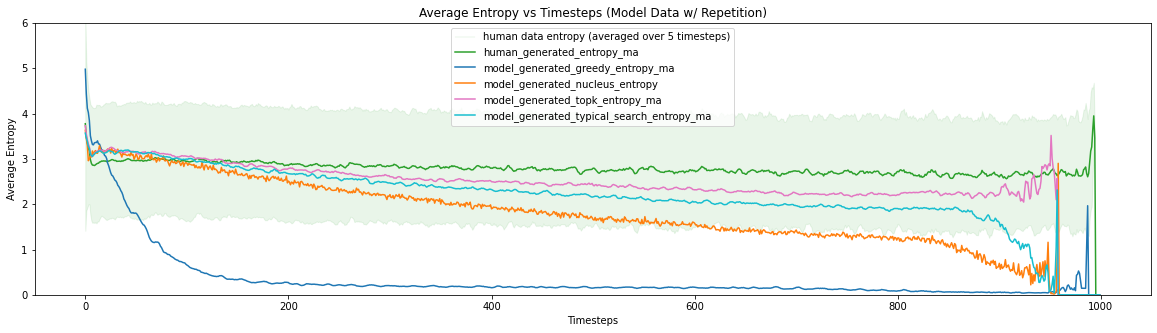

In [157]:
model_vs_human_avg_entropies = pd.concat([human_avg_ma_entropy_pd, model_gen_greedy_avg_ma_entropy_pd, model_gen_nucleus_avg_entropy_pd, model_gen_topk_avg_ma_entropy_pd, model_gen_typical_avg_ma_entropy_pd],axis=1)

fig, ax = plt.subplots(figsize=(20, 5))

plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

styles=['tab:green', 'tab:blue', 'tab:orange', 'tab:pink', 'tab:cyan']
model_vs_human_avg_entropies.plot( 
    title='Average Entropy vs Timesteps', 
    figsize=(20, 5),
    xlabel="Timesteps", 
    ylabel="Average Entropy",
    style=styles,
    ax=ax
)


# Do errors cascade?

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = human_dataframe[human_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_greedy_dataframe[model_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_topk_dataframe[model_entropy_topk_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_aware_greedy_dataframe[model_entropy_aware_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        xticks=range(0, 120, 5),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        )

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        # xticks=range(0, 128),
        yticks=np.arange(0, 11, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # label="CDF"
)

ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences (w/o length normalization.")